# Time Series Forecasting 2018-2020 Furniture Sales

In [1]:
import numpy as np
import pandas as pd
import datetime

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,4)
# plt.rcParams['figure.dpi'] = 150
plt.style.context('fivethirtyeight')
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from prettytable import PrettyTable  # pip install prettytable 

# modeling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

#
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# colors
colors = ['#F0D290','#DE834D','#A3423C','#781D42']
colors3 = ['#F0D290','#DE834D','#A3423C','#781D42','#671E31']
colors2 = ['#f0d290','#e9c083','#e2af77','#d99d6d','#d08c64',
          '#c67b5d','#bc6b56','#b05a51','#a34b4d','#963b49',
          '#872c45','#781d42']


## Data
This is a transnational dataset, which contains all the transactions occurring between 01/01/2014 and 31/12/2017 for a superstore. The superstore sells a wide variety of merchandise including furniture, office supplies and technology products. The dataset has around 10K rows and 21 columns. [dataset link](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls) <br>
**Goal: forecast the next three years of furniture sales (2018-2020).**

In [2]:
# loading data & check dataset shape
df = pd.read_excel('../datasets/Sample - Superstore.xls')
df.shape

(9994, 21)

# Data Exploration

#### Is there any missing values or duplicated rows ?
Answer : No

In [3]:
print(f'Number of missing values is {df.isna().sum().sum()}\nNumber of duplicated rows is {df.duplicated().sum()}')

Number of missing values is 0
Number of duplicated rows is 0


#### Exclude unnecessary columns

In [4]:
df = df[['Order Date', 'Product ID', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit']]

#### Is every column has the appropriate data type?
Anser : Yes

In [5]:
df.dtypes

Order Date      datetime64[ns]
Product ID              object
Category                object
Sub-Category            object
Sales                  float64
Quantity                 int64
Discount               float64
Profit                 float64
dtype: object

#### How much Furniture data represent out of the whole data? 
Answer : 21% <br>

Subcategories: <br>
45% Furnishings <br>
29% Chairs <br>
15% Tables <br>
11% Bookcases <br>

In [6]:
def plot_persantage(data1, data2, title1, title2, ):
    fig, axs = plt.subplots(1, 2, sharey=True)

    # plot Categories
    data = data1
    axs[0].pie(data, 
            labels=data.index,
            colors=colors,
            autopct='%.0f%%');
    axs[0].title.set_text(title1)

    # plot Furniture sub-categories
    data = data2
    axs[1].pie(data, 
            labels=data.index,
            colors=colors,
            autopct='%.0f%%');
    axs[1].title.set_text(title2)

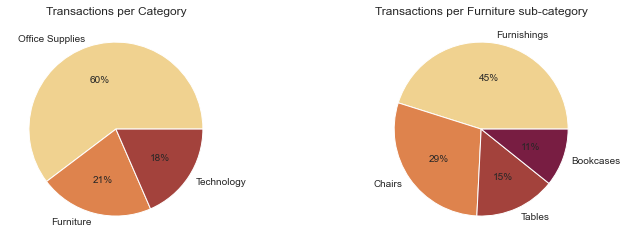

In [7]:
# plot NUMBER OF TRANSACTIONS of each Category and each Furniture sub-category
plot_persantage(data1=df['Category'].value_counts(),
                title1='Transactions per Category',
                data2=df[df['Category'] == 'Furniture']['Sub-Category'].value_counts(),
                title2='Transactions per Furniture sub-category');

#### How much SALES percentage for Furniture among other categories?
Answer : 32% <br>

Subcategories: <br>
44% Chairs <br>
28% Tables <br>
15% Bookcases <br>
12% Furnishings <br>

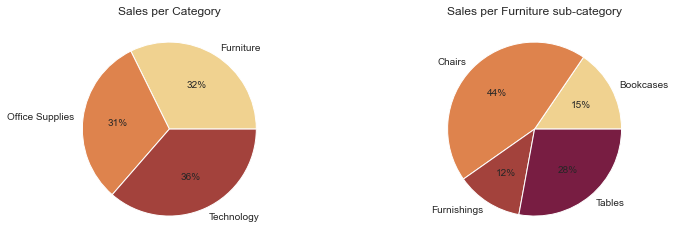

In [8]:
# plot SALES of each Category and each Furniture sub-category
plot_persantage(data1=df.groupby(['Category'])['Sales'].sum(),
                title1='Sales per Category',
                data2=df[df['Category'] == 'Furniture'].groupby(['Sub-Category'])['Sales'].sum(),
                title2='Sales per Furniture sub-category');

#### Since we are interested in Furniture category we will drop non-Furniture data

In [9]:
df = df[df['Category'] == 'Furniture'].reset_index(drop=True)
df.shape

(2121, 8)

#### Overall data description
- We are mostly interested in the Sales column, we can notice it has values as expected no negative values.
- We can notice Profit contain negative values, which is reasonable because of discounts.

In [10]:
# describe and EDA
df.describe().round(2)

,Sales,Quantity,Discount,Profit
count,2121.00,2121.00,2121.00,2121.00
mean,349.83,3.79,0.17,8.70
std,503.18,2.25,0.18,136.05
min,1.89,1.00,0.00,-1862.31
25%,47.04,2.00,0.00,-12.85
50%,182.22,3.00,0.20,7.77
75%,435.17,5.00,0.30,33.73
max,4416.17,14.00,0.70,1013.13


#### Any wrong data in the SALES column ?
Answer : No

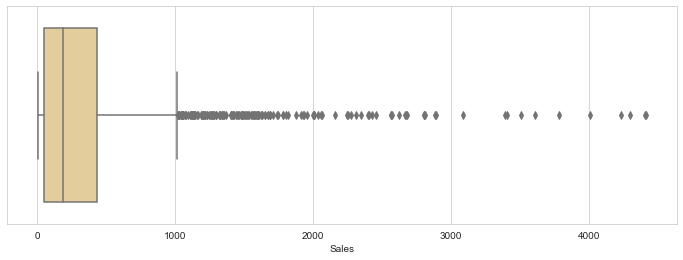

In [11]:
sns.boxplot(x=df['Sales'], color=colors[0]);

In [12]:
# # removing SALES outliers
# Q1 = df['Sales'].quantile(0.25)
# Q3 = df['Sales'].quantile(0.75)
# IQR = Q3 - Q1
# df = df[(df['Sales'] >= Q1 - 1.5 * IQR) & (df['Sales'] <= Q3 + 1.5 * IQR)]

In [13]:
# sns.boxplot(x=df['Sales'], color=colors[0]);

#### Extract YEAR, MONTH, and QUARTER for visualization purposes

In [14]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = (df['Month']-1)//3+1

#### FURNITURE SALES vs FURNITURE PROFIT over years

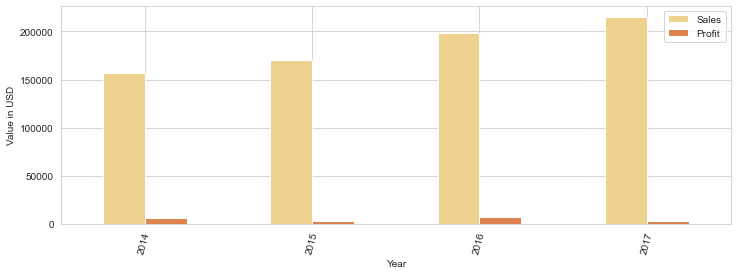

In [15]:
df.groupby(['Year'])[['Sales', 'Profit']].sum().plot.bar(color=colors, rot=75);
plt.ylabel('Value in USD');

#### Is there any missing dates? i.e (2014/1/1, 2014/1/2, 2014/1/4), 2014/1/3 is missing!
Answer : Yes, 565 day missing.

In [16]:
# first find the number of unique indices
l = len(df['Order Date'].unique())

# then calculate the delta in time plus one (inclusive of first day)
delta = df['Order Date'].max() - df['Order Date'].min()

# number of missing dates 
print(f'Number of missing dates : {delta.days - l}')

Number of missing dates : 565


#### missing values in daily SALES

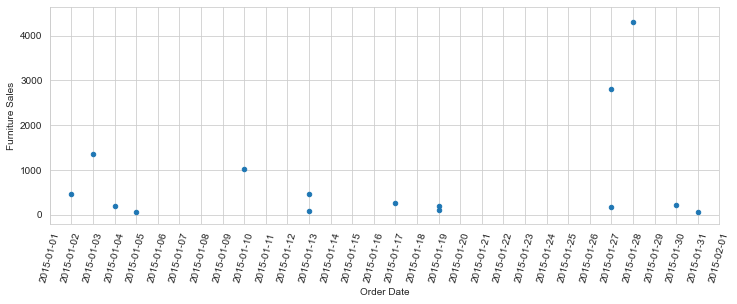

In [17]:
df[['Order Date', 'Sales']].plot.scatter(x='Order Date', y='Sales', rot=75);
plt.ylabel('Furniture Sales');
plt.xticks(pd.date_range(datetime.datetime(2014,1,1), datetime.datetime(2017,12,31)));
plt.xlim(datetime.datetime(2015,1,1),datetime.datetime(2015,2,1));

#### Is the Sales column take into consideration the Quantity & Discount? 
Answer : Yes

In [18]:
df_ = df[df['Product ID'] == 'FUR-BO-10001798'][['Order Date', 'Product ID', 'Quantity', 'Sales', 'Discount']]
df_['Sales of Single Product'] = df_['Sales'] / df_['Quantity']
df_['Price of Single Product without Discount'] = df_['Sales of Single Product'] / (1 - df_['Discount'])
df_

,Order Date,Product ID,Quantity,Sales,Discount,Sales of Single Product,Price of Single Product without Discount
0,2016-11-08,FUR-BO-10001798,2,261.960,0.00,130.980,130.98
1121,2016-04-09,FUR-BO-10001798,5,556.665,0.15,111.333,130.98
1837,2017-08-25,FUR-BO-10001798,2,130.980,0.50,65.490,130.98
1976,2017-05-01,FUR-BO-10001798,3,314.352,0.20,104.784,130.98


#### Quarterly FURNITURE SALES
Note : Data has Seasonality

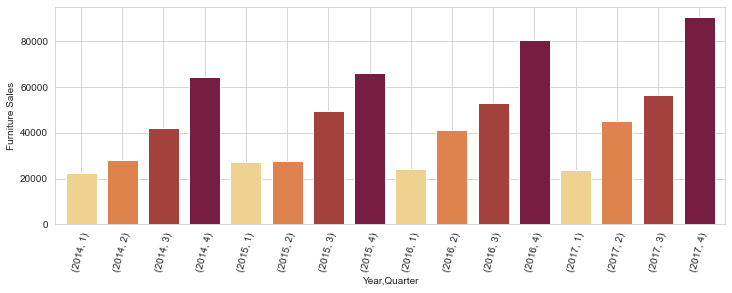

In [19]:
df.groupby(['Year', 'Quarter'])['Sales'].sum().plot.bar(color=colors, width=0.75, rot=75);
plt.ylabel('Furniture Sales');

#### Monthly FURNITURE SALES

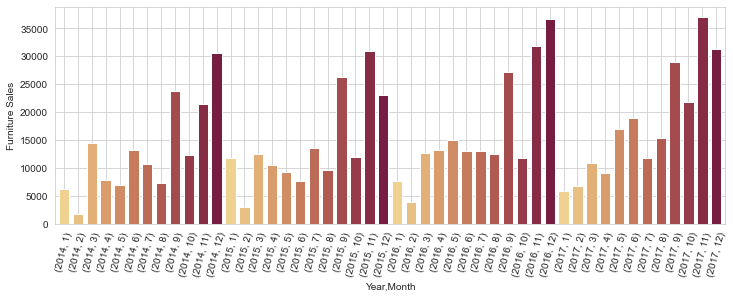

In [20]:
df.groupby(['Year', 'Month'])['Sales'].sum().plot.bar(color=colors2, width=0.75, rot=75);
plt.ylabel('Furniture Sales');

#### Comparing yearly FURNITURE SALES over months

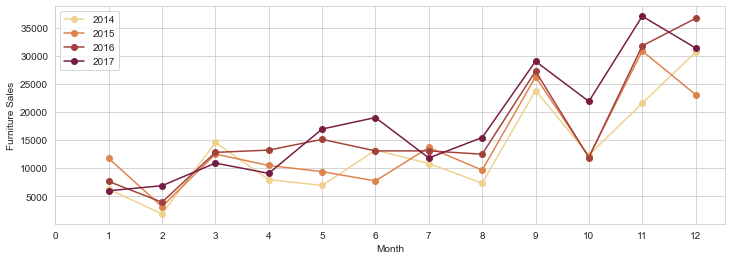

In [21]:
df[df['Year'] == 2014].groupby(['Month'])['Sales'].sum().plot.line(color=colors[0], marker='o');
df[df['Year'] == 2015].groupby(['Month'])['Sales'].sum().plot.line(color=colors[1], marker='o');
df[df['Year'] == 2016].groupby(['Month'])['Sales'].sum().plot.line(color=colors[2], marker='o');
df[df['Year'] == 2017].groupby(['Month'])['Sales'].sum().plot.line(color=colors[3], marker='o');

plt.xticks(range(0,13));
plt.ylabel('Furniture Sales');
plt.legend(['2014', '2015', '2016', '2017']);

#### FURNITURE SALES Trend
Note : Data has increasing trend

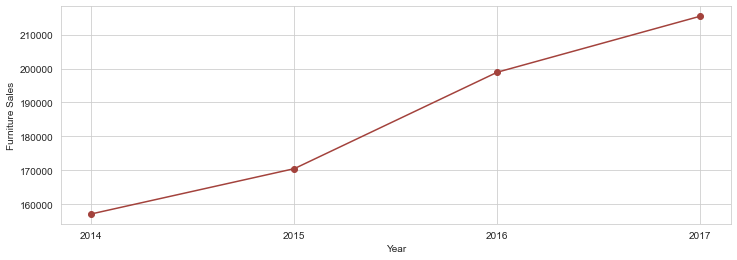

In [22]:
df.groupby(['Year'])['Sales'].sum().plot.line(color=colors[2], marker='o');
plt.xticks(sorted(df['Year'].unique()));
plt.ylabel('Furniture Sales');

#### Plot with smoothing  random changes & removing outliers
Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

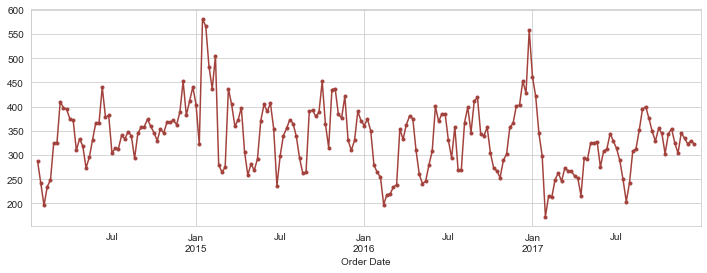

In [23]:
df_ = df[['Order Date', 'Sales']].set_index('Order Date')

# plot 5-week centered rolling mean
weekly_average_sales = df_.Sales.resample('W').mean().fillna(0)
weekly_average_sales.rolling(window=5, center=True).mean().plot(color=colors[2], marker='.');

## Data Preprocessing

#### Drop unnecessary columns and removing missing values by taking weekly SALES

In [24]:
# df = df[['Order Date', 'Sales']].sort_values('Order Date').reset_index(drop=True)

In [25]:
# df_daily = df.set_index('Order Date')['Sales'].resample('D').sum().to_frame()

In [26]:
df_weekly = df.set_index('Order Date')['Sales'].resample('W').sum().to_frame()

In [27]:
# df_monthly = df.set_index('Order Date')['Sales'].resample('M').sum().to_frame()

## Model Selection

In [28]:
models_results_rmse = {}
models_results_r2 = {}

#### Find highest correlated Lag
Note : best is LAG ~= 52

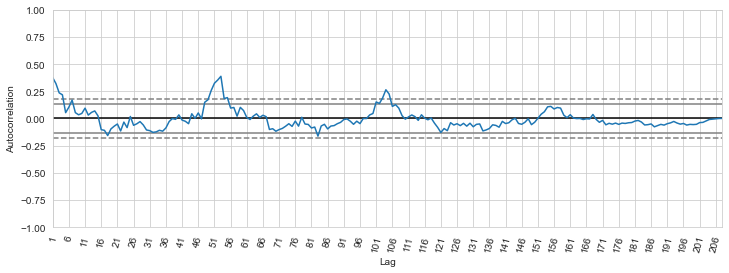

In [29]:
# plot autocorrelation
autocorrelation_plot(df_weekly)
plt.xticks(range(1, 209, 5), rotation=75)
plt.grid()
plt.show()

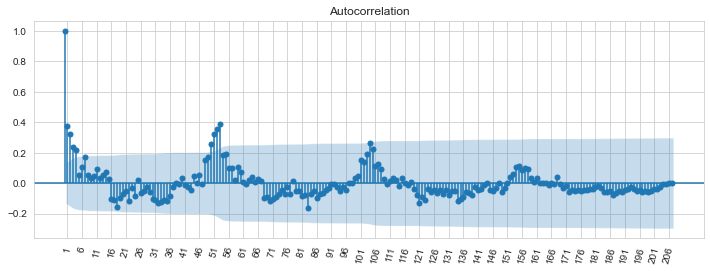

In [30]:
plot_acf(df_weekly, lags=207)
plt.xticks(range(1, 209, 5), rotation=75)
plt.show()

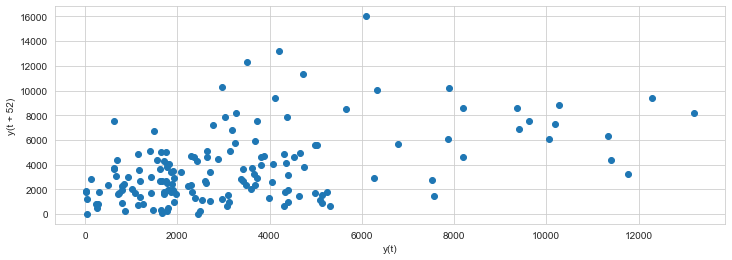

In [31]:
# plot correlation for lag=53
lag_plot(df_weekly, lag=52)
plt.show()

#### helper functions

In [32]:
def evaluate(y_t, y_p, title):
    table = PrettyTable()
    table.field_names = ['Metric', 'Value']
    
    rmse = mean_squared_error(y_t, y_p, squared=False).round(4)
    r2 = r2_score(y_t, y_p).round(4)
    
    table.add_row(['RMSE', rmse])
    table.add_row(['R2 Score', r2])
    
    models_results_rmse[title] = rmse
    models_results_r2[title] = r2
    
    print(table)

In [33]:
# adding Lag function
def lag_dataset(df_temp_, lag):
    df__ = df_temp_.copy()
    for i in range(1, lag+1):
        df__['L' + str(i)] = df__['Sales'].shift(i)
    return df__.dropna(how='any')

In [34]:
# 5. plot predictions and expected results
def plot_forecasted_sales(y_pred, y_train, y_true=[], period=5):
    plt.plot(y_train.to_list(), color=colors[0])
    plt.plot([None for i in y_train] + [x for x in y_pred], color=colors[2])
    if len(y_true) > 0:
        plt.plot([None for i in y_train] + [x for x in y_true], color=colors[1])
        plt.legend(['2014-2016 Acual SALES', '2017 Acual SALES', f'2017 Forecasted SALES RMSE={mean_squared_error(y_true, y_pred, squared=False).round(1)}'])
    else:
        plt.legend(['2014-2017 Acual SALES', '2018-2020 Forecasted SALES'])
    plt.xticks(range(0, len(y_train) + len(y_pred), period), rotation=75)
#     plt.xticks(rotation=75)
    plt.xlabel('Week')
    plt.ylabel('Sales')
    # plt.xlim(85,) # zoom
    plt.show()

## Develop & Evaluate models

### 01 Develop NAÏVE Model
Notes : <br>
This is a naive non-trainable persistence model, limited in prediction.

In [35]:
# 1. create t+1 column
values = pd.DataFrame(df_weekly['Sales'].values)
df_ = pd.concat([values.shift(1), values], axis=1)
df_.columns = ['X', 'y']

In [36]:
# 2. split into train and test sets
df_ = df_.dropna(how='any')
train_X, test_X, train_y, test_y = train_test_split(
    df_['X'], df_['y'], train_size=0.66, shuffle=False)

In [37]:
# 3. persistence model
def model_persistence(x):
    return x

In [38]:
# 4. walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

# evaluation
evaluate(test_y, predictions, title='NAÏVE Model')

+----------+-----------+
|  Metric  |   Value   |
+----------+-----------+
|   RMSE   | 3149.0964 |
| R2 Score |   -0.048  |
+----------+-----------+


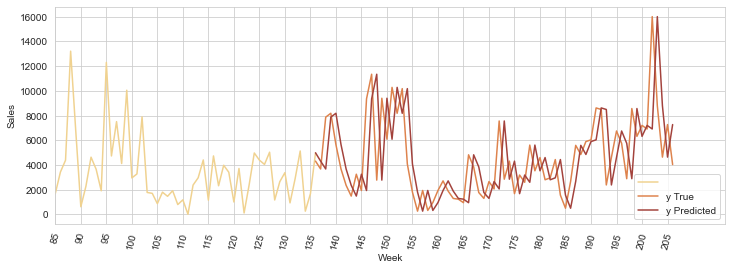

In [39]:
# 05
# plot predictions and expected results
plt.plot(train_y, color=colors[0])
plt.plot([None for i in train_y] + [x for x in test_y], color=colors[1])
plt.plot(([None for i in train_y] + [x for x in predictions]), color=colors[2])
plt.legend(['', 'y True', 'y Predicted'])
plt.xticks(range(0, 207, 5), rotation=75)
plt.xlabel('Week')
plt.ylabel('Sales')
plt.xlim(85,) # zoom
plt.show()

### 02 Develop Linear Regression + Lag=1

In [40]:
def linear_regression_test(lag):
    # 1. Lag
    df_ = lag_dataset(df_weekly, lag)

    # 2. Split 
    X_train, X_test, y_train, y_test = train_test_split(
        df_.drop(['Sales'], axis=1), df_['Sales'], test_size=0.33, shuffle=False)
    
    # 3. fitting linear regression
    reg = LinearRegression().fit(X_train, y_train)
    
    # 4. forecast / predict
    y_pred = reg.predict(X_test)

    # 5. evaluation
    evaluate(y_test, y_pred, title='Linear Regression lag=' + str(lag))
    
    # plot results
    plot_forecasted_sales(y_train=y_train, y_true=y_test, y_pred=y_pred)

+----------+-----------+
|  Metric  |   Value   |
+----------+-----------+
|   RMSE   | 3140.5911 |
| R2 Score |  -0.0145  |
+----------+-----------+


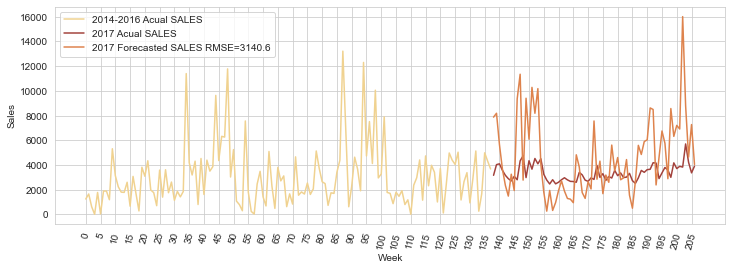

In [41]:
linear_regression_test(lag=1)

### 03 Develop 1st, 2nd and 3rd degree polynomial + Lag
Notes:
- 1st degree (Linear Regression) + Lag=52 are the best
- We tried 3 different degrees - 1st degree (Linear Regression), 2nd degree, and 3rd degree.
- BEST RESULT goes to Linear regression with lag=52, with RMSE = 2353.3.
- Also the three models show relatively good results with lag=51, 2nd degree model with RMSE = 2490.9, and 3rd degree model with RMSE = 2542.6.


In [42]:
mse_ = [[],[],[]]

best_models = [None, None, None]

# trying 1st (Linear Regression), 2nd and 3rd degree
for degree in range(1, 4):
    
    lags = []
    
    # trying lag from 1 to 60
    for lag in range(1, 60, 1):

        # 1. Lag
        df_ = lag_dataset(df_weekly, lag)
        df_ = df_.dropna(how='any')

        # 2. Split 
        X_train, X_test, y_train, y_test = train_test_split(
            df_.drop(['Sales'], axis=1), df_['Sales'], test_size=0.33, shuffle=False)

        # 3.1 fitting polynomial
        poly_reg = PolynomialFeatures(degree=degree)
        X_poly = poly_reg.fit_transform(X_train)
        pol_reg = LinearRegression()
        pol_reg.fit(X_poly, y_train)
        y_pred = pol_reg.predict(poly_reg.fit_transform(X_test))

        # compute MSE/RMSE
        mse = mean_squared_error(y_test, y_pred, squared=False).round(1)
        
        # save best model of each degree 
        if len(mse_[degree-1]) != 0 and mse < min(mse_[degree-1]):
            best_models[degree-1] = pol_reg
            
        # store mse/rmse for visualization
        mse_[degree-1].append(mse)
        lags.append(lag)
        

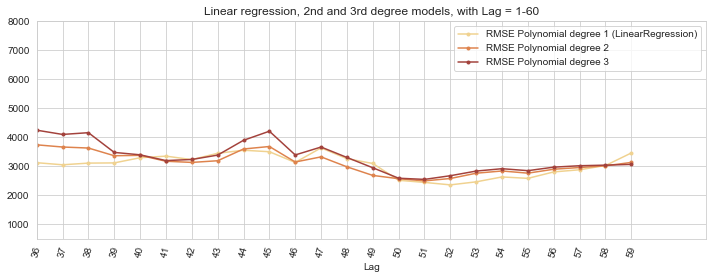

In [65]:
pd.DataFrame({'Lag':lags, 
              'RMSE Polynomial degree 1 (LinearRegression)':mse_[0], 
              'RMSE Polynomial degree 2':mse_[1], 
              'RMSE Polynomial degree 3':mse_[2]}).set_index('Lag').plot(color=colors, marker='.', rot=75);
plt.xticks(lags);
plt.ylim(500, 8000); # zoom
plt.xlim(36, ); # zoom
plt.title('Linear regression, 2nd and 3rd degree models, with Lag = 1-60');

### 04 Develop Linear Regression with Lag=52

+----------+-----------+
|  Metric  |   Value   |
+----------+-----------+
|   RMSE   | 2353.2641 |
| R2 Score |   0.3405  |
+----------+-----------+


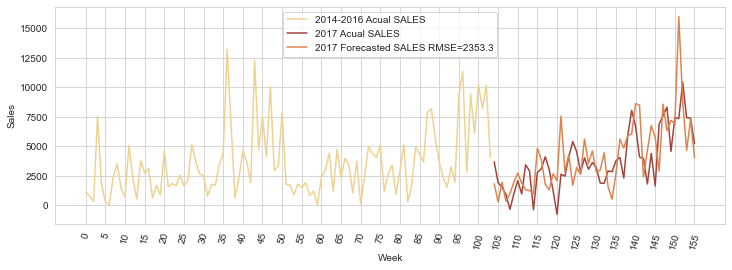

In [44]:
linear_regression_test(lag=52)

### Develop  ARIMA

In [45]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

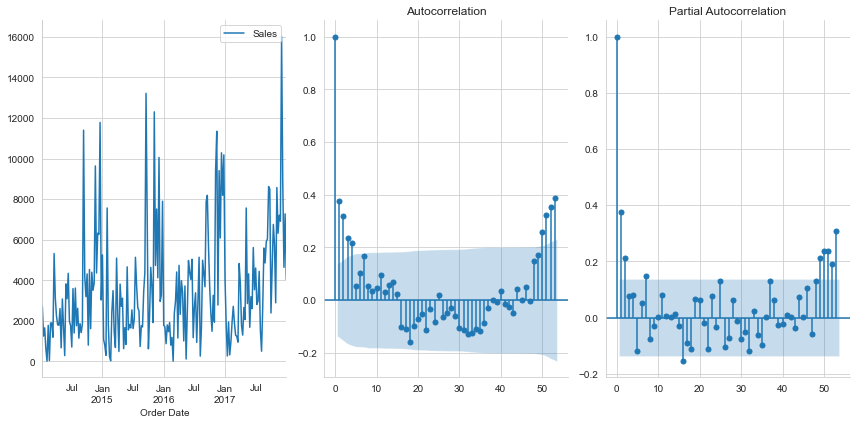

In [46]:
# helper plot
plots(df_weekly, lags=53);

In [47]:
# fit SARIMA monthly based on helper plots
ar = ARIMA(df_weekly, order=(1,0,51)).fit()
# ar.summary()

C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
# plot resids
# plots(ar.resid, lags=60);

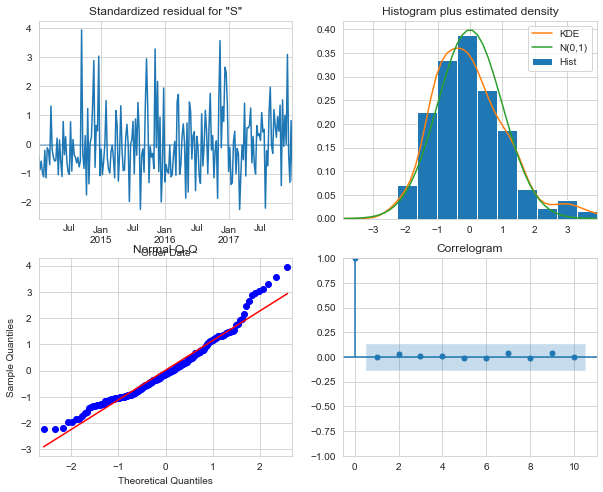

In [49]:
# plot residual diagnostics
ar.plot_diagnostics(figsize=(10, 8));

+----------+-----------+
|  Metric  |   Value   |
+----------+-----------+
|   RMSE   | 2133.9629 |
| R2 Score |   0.4577  |
+----------+-----------+


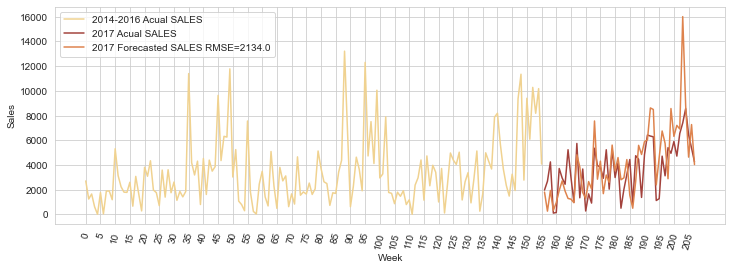

In [50]:
# 
df_ = df_weekly.copy()
df_['forecast'] = ar.predict(start=156, end=208, dynamic=20)  
# df_[['Sales', 'forecast']].plot(color=colors);

# evaluation
evaluate(df_[156:]['Sales'], df_[156:]['forecast'],  title='ARIMA')

# plot results
plot_forecasted_sales(y_train=df_[:-52]['Sales'], y_true=df_[-52:]['Sales'], y_pred=df_['forecast'].dropna())

### Develop SARIMA

In [51]:
# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(df_weekly, order=(1,0,26), seasonal_order=(1,1,1,52), trend='ct').fit()

C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


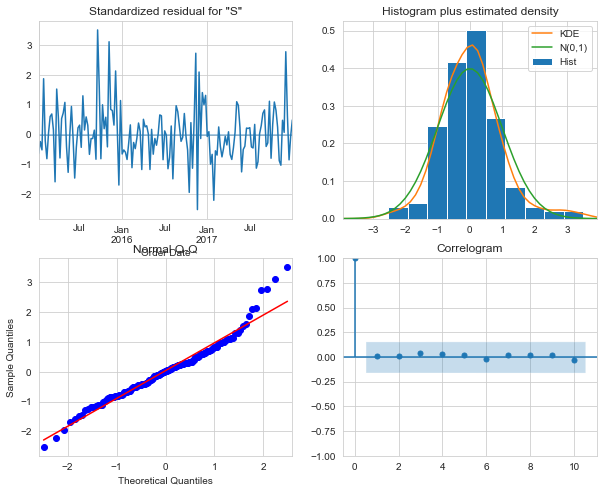

In [52]:
# plot residual diagnostics
sar.plot_diagnostics(figsize=(10, 8));

+----------+----------+
|  Metric  |  Value   |
+----------+----------+
|   RMSE   | 1906.243 |
| R2 Score |  0.5673  |
+----------+----------+


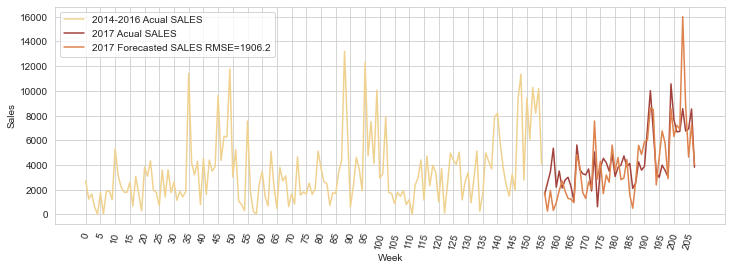

In [53]:
# 
df_ = df_weekly.copy()
df_['forecast'] = sar.predict(start=156, end=208, dynamic=20)  
# df_[['Sales', 'forecast']].plot(color=colors);

# evaluation
evaluate(df_[156:]['Sales'], df_[156:]['forecast'], title='SARIMA')

# plot results
plot_forecasted_sales(y_train=df_[:-52]['Sales'], y_true=df_[-52:]['Sales'], y_pred=df_['forecast'].dropna())

## Forecasting

###  01 Forecasting 2018-2020 using Linear Regression

In [54]:
# create empty frame for the next 3 years
dates_ = pd.date_range(start=datetime.datetime(2018,1,1) , end=datetime.datetime(2020,12,31), freq='W')
sales = [0]*len(dates_)
dates_to_predict = pd.DataFrame({'Order Date':dates_, 'Sales':sales}).set_index('Order Date')

In [55]:
# next 3 years have 156 week
weeks_to_predict = 156

In [56]:
# predict next 3 years SALES weekly wise using best base models (linear regression lag=53)

df_ = df_weekly.copy() 
for i in range(weeks_to_predict):
    
    # Lag
    df_ = lag_dataset(df_weekly.append(dates_to_predict[0:i+1]), 52)
        
    # split into train and test
    X = df_.drop('Sales', axis=1).copy()
    y = df_['Sales']
    X_train, X_test, y_train, y_test = X[:-1], X[-1:], y[:-1], y[-1:]

    # fit linear model with best lag founded
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # store
    dates_to_predict.iloc[i]['Sales'] = y_pred

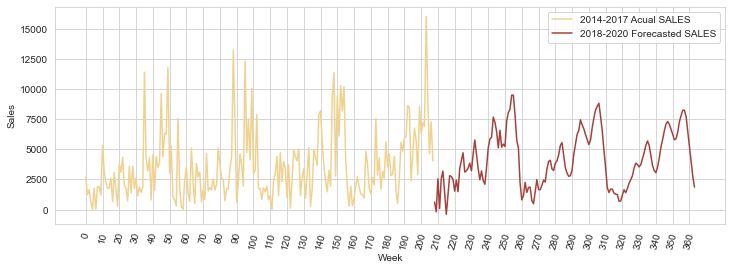

In [57]:
# plot results
plot_forecasted_sales(y_train=df_weekly['Sales'], y_pred=dates_to_predict['Sales'].to_list(), period=10)

### 02 Forecasting 2018-2020 using ARIMA

In [58]:
# forecast 2018-2020
# y_pred = ar.predict(start=208, end=364).iloc[-158:]
# y_test = df_weekly.Sales

In [59]:
# plot results
# plot_forecasted_sales(y_train=y_test, y_pred=y_pred)

### 03 Forecasting 2018-2020 using SARIMA

In [60]:
# forecast 2018-2020
y_pred = sar.predict(start=208, end=364).iloc[-158:]
y_test = df_weekly.Sales

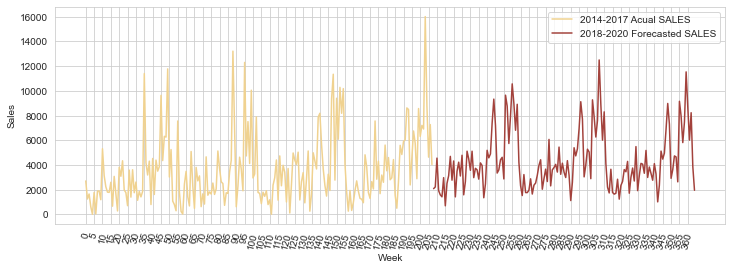

In [61]:
# plot results
plot_forecasted_sales(y_train=y_test, y_pred=y_pred)

## Conclusion

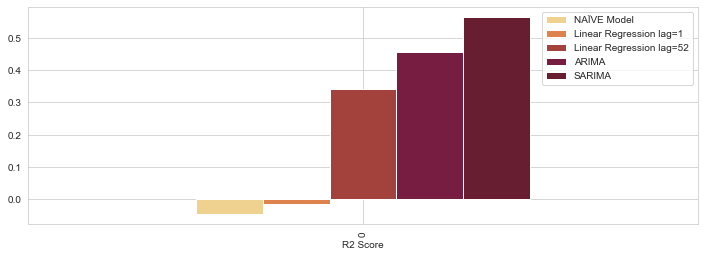

In [62]:
pd.DataFrame(models_results_r2, index=[0]).plot.bar(color=colors3);
plt.xlabel('R2 Score');

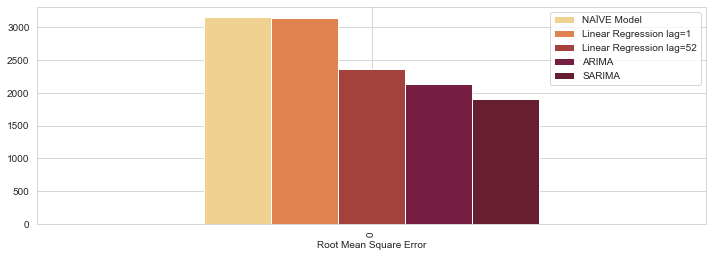

In [63]:
pd.DataFrame(models_results_rmse, index=[0]).plot.bar(color=colors3);
plt.xlabel('Root Mean Square Error');

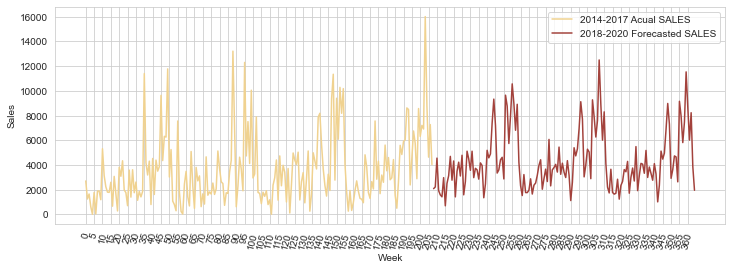

In [64]:
# final forecasting using SARIMA
y_pred = sar.predict(start=208, end=364).iloc[-158:]
y_test = df_weekly.Sales
plot_forecasted_sales(y_train=y_test, y_pred=y_pred)